In [87]:
from distutils.command import config

def random_search(problem, function_evaluations=150, **kwargs):

    history = []
    configs = []

    RANGES = GET_RANGES(problem) 

    for j in range(function_evaluations):
        config={}
        
        for i in RANGES:
            # If there is a condition, check if it holds.
            # If not, skip this hyperparameter
            if(condition(RANGES, config, i)):
                continue
            
            a = RANGES[i]['range'][0] 
            b = RANGES[i]['range'][1] 
            
            # If uniform
            if(RANGES[i]['sample']==0):
                if (RANGES[i]["type"] == 0):
                    value=np.random.choice(RANGES[i]['range']) 
                    config[i]=value  
                elif (RANGES[i]["type"] == 1):
                    value=np.random.uniform(a, b) 
                    config[i]=value
                else:
                    value=np.random.randint(a, b+1) 
                    config[i]=value
            # Else log        
            else:
                value=np.random.uniform(np.log(a), np.log(b)) 
                value = np.exp(value)
                if RANGES[i]['type'] == 2:
                    value = round(value)
                config[i]=value # exponentiate value back 
        if problem != 'interactive':        
            config['nodes_per_layer'] = return_node_list(config)        
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config, problem))

    return history, configs

# Function for checking if hyperparameter has a condition and whether it holds
def condition(ranges, config, i):
        if('condition' in ranges[i]):
            if (ranges[i]['condition'](config) == False):
                return True

In [88]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm
import math


def ugly_condition_check(x_star, i): 
    if 'nlayers' in x_star.keys():
        layers = x_star['nlayers']
        if i[-1].isdigit():
            if int(i[-1]) > layers:
                return True


def tpe2(problem, function_evaluations=150, random_warmup=30, gamma=0.1, n=10, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    loss,configs=random_search(problem,random_warmup)    
    
    hyperparameters = to_df(configs, loss)    
    EI_plot_=[]
    for k in range(function_evaluations):
        
        good_df, bad_df = good_bad(gamma, hyperparameters)
        x_star = {}
         
        EI_plot=[]
        for i in good_df.columns.difference(['loss', 'nodes_per_layer']): 
            x = good_df[i].dropna().values.tolist()
            y = bad_df[i].dropna().values.tolist()
            full = x + y
            
            a = RANGES[i]['range'][0]
            b = RANGES[i]['range'][1]
                
            if(ugly_condition_check(x_star, i)):
                 continue
            
            # If categorical, sample uniform
            if RANGES[i]['type'] == 0:
                sample = sample_uniform(RANGES[i])
                x_star[i] = sample 
                
            else:
                if RANGES[i]['sample'] == 1:
                    x = np.log(x)
                    y = np.log(y)
                    full = np.log(full)
                    a, b = np.log(a), np.log(b)
                    
                # Sort because we need the sd to the furthest neighbour
                x.sort()                  
                y.sort()
                full.sort()

                std_full = scales(full, a, b)
                samples = sample_truncnorm(a, b, full, std_full, n)
                
                max_sd, max_sd_y = 0, 0

                if len(x) > 0:
                    max_sd = scales(x, a, b)
                if len(y) > 0:
                    max_sd_y = scales(y, a, b)

                #samples = sample_truncnorm(a, b, x, max_sd, n)
                
                EI = get_EI(samples, x, y, a, b, max_sd, max_sd_y)

                EI_max = np.argmax(EI)
                EI_plot.append(np.max(EI))
                value = samples[EI_max]
                if RANGES[i]['sample'] == 1:
                    value = np.exp(value)
                if RANGES[i]['type'] == 2:
                    value = round(value)      
                x_star[i] = value
                
        if problem != 'interactive':
            x_star['nodes_per_layer'] = return_node_list(x_star)
            
        x_star['loss'] = GET_CONFIG_PERFORMANCE(x_star, problem) 
        EI_plot_.append(EI_plot)
        hyperparameters = hyperparameters.append(x_star, ignore_index=True)
        
    best_hp = hyperparameters.iloc[hyperparameters['loss'].idxmin()]
    return hyperparameters,EI_plot_

def get_EI(samples, x, y, a, b, max_sd, max_sd_y):
    EI = []
    for j in range(len(samples)):   
        lx = 1
        gx = 1
        if len(x) > 0 and len(y)>0:
            lx = get_pdf(samples[j], x, a, b, max_sd)     

        if len(y) > 0:
            gx = get_pdf(samples[j], y, a, b, max_sd_y)
        
        if gx > 0:
            EI.append(lx/gx)
        else:
            EI.append(lx)
    return EI

def return_node_list(x):
    nodes= []
    for i in x.keys():
        if 'nodes_in_layer' in i:
            nodes.append(x[i])
    return nodes
        
def to_df(configs, loss):

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss
    
    hyper_parameters_1 = (hyper_parameters["configs"].apply(pd.Series))
    hyper_parameters_1['loss'] = hyper_parameters["loss"]
    
    
    return hyper_parameters_1
            
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, hyper_parameters):

    sorted_df=(hyper_parameters.sort_values(by=["loss"])).reset_index(drop=True)
    
    index_value=int(gamma*(sorted_df.shape[0]))
    
    good_df = sorted_df.iloc[:index_value]
    bad_df = sorted_df.iloc[index_value:sorted_df.shape[0]]
            
    return good_df, bad_df

def sample_truncnorm(a, b, x, sd, n):
    index = np.random.choice(range(len(x)))
    a, b = (a - x[index]) / sd[index], (b - x[index]) / sd[index]
    samples = stats.truncnorm.rvs(a, b, loc=x[index], scale=sd[index], size=n)
    return samples

def get_pdf(x_i, x, a, b, sd):
    n = len(x)
    total = 0
    
    for i in range(n):
        mean = x[i]
        sigma = sd[i]
        a, b = (a - mean) / sigma, (b - mean) / sigma
        total += stats.truncnorm.pdf(x_i, a, b, loc=mean, scale=sigma)
       # if error == 'error':
       #     print(x_i, a, b, mean, sigma)
        
    return total/n

def scales(x, a, b):
    if len(x) > 1:
        diff = np.diff(x)
    else:
        diff = [0]
    epsilon = (b-a)/min(100,len(x)+2)
    scales = []
    for i in range(0, len(diff)):
        max_ = max(diff[i-1], diff[i], epsilon)
        sigma = min(max_, b-a)
        scales.append(sigma)        
    scales.insert(0,min(max(diff[0], epsilon), b-a))
    scales.insert(-1,min(max(diff[-1], epsilon), b-a))
    
    return scales

def sample_uniform(hyperparameter):
    sample = np.random.choice(hyperparameter['range'])    
    return sample

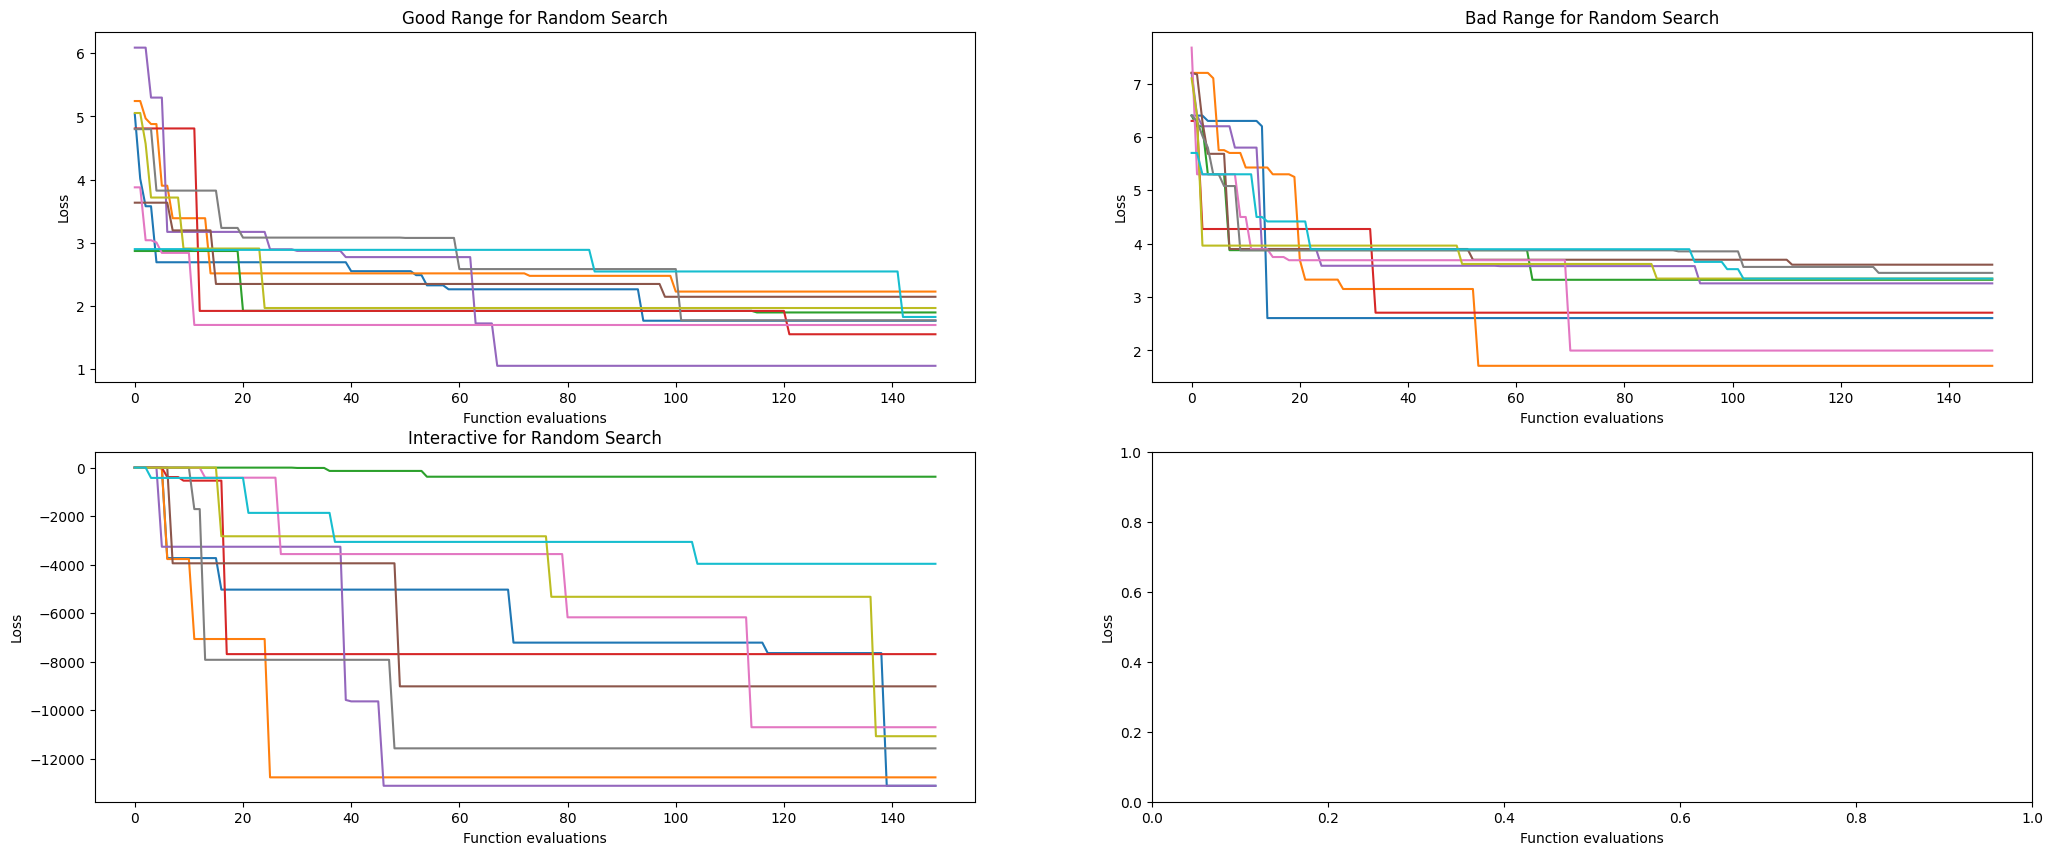

In [89]:
trails = 10

fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(25,10))

for j in range(trails):
    losses,config = random_search("good_range")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0][0].plot(range(len(losses)-1),loss)   
    axs[0][0].title.set_text("Good Range for Random Search")
    
for j in range(trails):
    losses,config = random_search("bad_range")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[0][1].plot(range(len(losses)-1),loss) 
    axs[0][1].title.set_text("Bad Range for Random Search")
    
for j in range(trails):
    losses,config = random_search("interactive")
    loss=[]
    for i in range(1,len(losses)):
        loss.append(min(losses[:i]))        
    axs[1][0].plot(range(len(losses)-1),loss) 
    axs[1][0].title.set_text("Interactive for Random Search")
    
for ax in axs.flat:
    ax.set(xlabel='Function evaluations', ylabel='Loss')
plt.show()

C:\Users\mally\AppData\Local\Temp\ipykernel_24204\2628303927.py:112: RuntimeWarning: overflow encountered in double_scalars
  EI.append(lx/gx)
C:\Users\mally\AppData\Local\Temp\ipykernel_24204\2628303927.py:112: RuntimeWarning: overflow encountered in double_scalars
  EI.append(lx/gx)


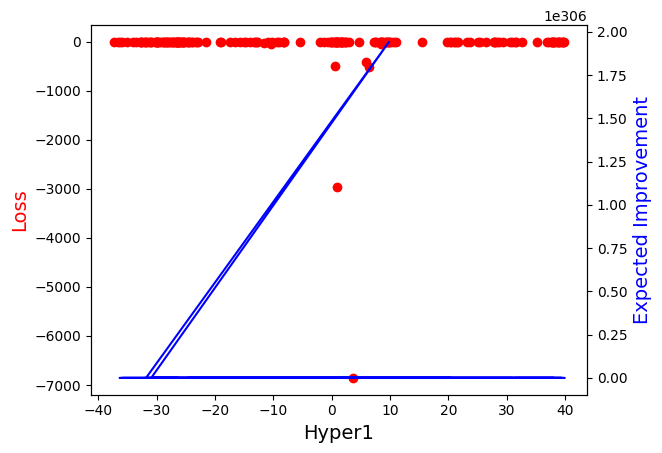

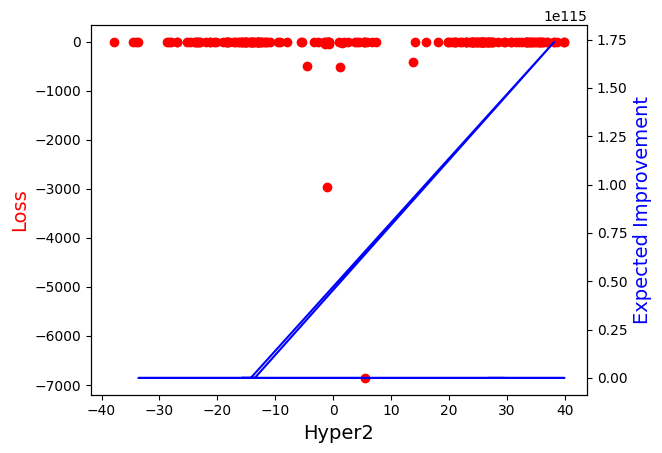

In [86]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df,EI_plot= tpe2("interactive")

fig,ax = plt.subplots()
ax.scatter(df["hyper1"],df["loss"],color="red",marker="o")
ax.set_xlabel("Hyper1", fontsize = 14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df["hyper1"][30:],EI_plot["hyper1"],color="blue")
ax2.set_ylabel("Expected Improvement",color="blue",fontsize=14)
plt.show()

fig,ax = plt.subplots()
ax.scatter(df["hyper2"],df["loss"],color="red",marker="o")
ax.set_xlabel("Hyper2", fontsize = 14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df["hyper2"][30:],EI_plot["hyper2"],color="blue")
ax2.set_ylabel("Expected Improvement",color="blue",fontsize=14)
plt.show()

In [84]:
pd.set_option('display.max_rows', 500)
EI_plot

,hyper1,hyper2
0,8.438657e-02,5.737532e+131
1,5.054902e-03,7.583429e-02
2,4.777620e-03,7.583722e-02
3,2.280960e+178,1.142394e+00
4,2.025755e-03,1.361887e-03
5,3.297097e-03,2.447804e-01
6,8.084101e-02,1.550475e+33
7,5.309034e-03,1.341034e+00
8,3.764573e-04,5.115322e+63
9,7.398112e+289,1.403511e-03


In [85]:
df

,hyper1,hyper2,loss
0,12.799604,-15.729912,-1.874084e-09
1,-33.452067,30.378038,-3.260963e-40
2,31.926566,-32.205715,-1.931812e-52
3,11.892117,1.821381,-2.266491e+00
4,-6.395826,1.635485,-1.609698e+03
5,-29.884387,36.629900,-2.263028e-41
6,25.370804,33.723872,-1.928651e-17
7,30.874373,10.169822,-1.479844e-17
8,-30.988581,-6.723644,-1.527611e-17
9,6.185837,-36.630763,-1.488507e-26


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df,EI_plot= tpe2("interactive")

fig,ax = plt.subplots()
ax.scatter(df["hyper1"],df["loss"],color="red",marker="o")
ax.set_xlabel("Hyper1", fontsize = 14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df["hyper1"][30:],EI_plot["hyper1"],color="blue")
ax2.set_ylabel("Expected Improvement",color="blue",fontsize=14)
plt.show()

fig,ax = plt.subplots()
ax.scatter(df["hyper2"],df["loss"],color="red",marker="o")
ax.set_xlabel("Hyper2", fontsize = 14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df["hyper2"][30:],EI_plot["hyper2"],color="blue")
ax2.set_ylabel("Expected Improvement",color="blue",fontsize=14)
plt.show()